# keras와 Pytorch비교
* make date : 2024-03-27
* 신재호

# keras cifar10분류

In [1]:
from keras.datasets import cifar10
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.metrics import confusion_matrix

(X_train, y_train), (X_val, y_val) = cifar10.load_data()
label_name = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 14s 0us/step


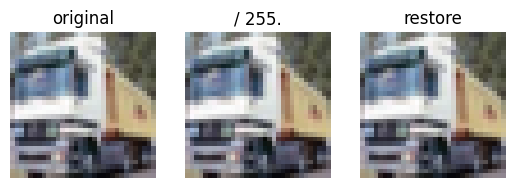

In [2]:
plt.subplot(1,3,1)
plt.imshow(X_train[1])
plt.axis('off')
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(X_train[1]/255.)
plt.axis('off')
plt.title('/ 255.')

plt.subplot(1,3,3)
a = X_train[1]/255. * 255.
plt.imshow(a.astype(int))
plt.axis('off')
plt.title('restore')

plt.show()

In [3]:
X_train = X_train.reshape(-1,32,32,3)/255.
X_val = X_val.reshape(-1,32,32,3)/255.

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

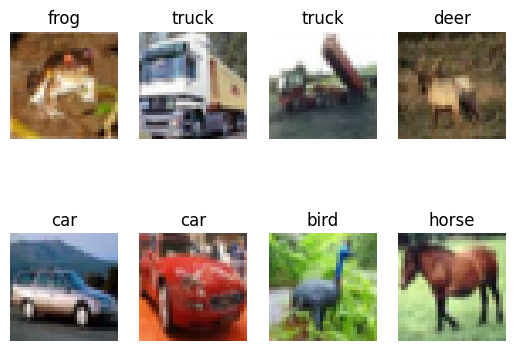

In [4]:
for i in range(8):
  plt.subplot(2,4,i+1)
  restor_X = X_train[i] * 255.
  plt.imshow(restor_X.astype(int))
  plt.title(f'{label_name[y_train[i].argmax(0)]}')
  plt.axis('off')

In [5]:
class DataLoader(Sequence):
  def __init__(self, batch_size, X, y):
    self.batch_size = batch_size
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    start, end = idx * self.batch_size, (idx + 1) * self.batch_size
    return self.X[start:end], self.y[start:end]

  def __len__(self):
    return math.ceil(len(self.y)/self.batch_size)

def Simple_CNN():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation="relu",input_shape=(32,32,3)))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(3,3),activation="relu"))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation = 'relu'))
  model.add(Dense(10, activation = 'softmax'))
  return model

In [6]:
train_loader = DataLoader(32, X_train, y_train)
val_loader = DataLoader(32, X_val, y_val)


model = Simple_CNN()
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['acc'])
model_checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, verbose=1,
                                   filepath = '/content/keras_CNN.keras')
history = model.fit(train_loader, validation_data = val_loader, epochs = 10, callbacks = [model_checkpoint])

Epoch 1/10
1561/1563 [============================>.] - ETA: 0s - loss: 1.4482 - acc: 0.5198
Epoch 1: val_loss improved from inf to 1.22152, saving model to /content/keras_CNN.keras
1563/1563 [==============================] - 27s 13ms/step - loss: 1.4478 - acc: 0.5199 - val_loss: 1.2215 - val_acc: 0.5711
Epoch 2/10
1561/1563 [============================>.] - ETA: 0s - loss: 0.8023 - acc: 0.7175
Epoch 2: val_loss improved from 1.22152 to 1.07167, saving model to /content/keras_CNN.keras
1563/1563 [==============================] - 13s 9ms/step - loss: 0.8023 - acc: 0.7174 - val_loss: 1.0717 - val_acc: 0.6371
Epoch 3/10
1561/1563 [============================>.] - ETA: 0s - loss: 0.4626 - acc: 0.8429
Epoch 3: val_loss did not improve from 1.07167
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4625 - acc: 0.8429 - val_loss: 1.1196 - val_acc: 0.6464
Epoch 4/10
1558/1563 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9433
Epoch 4: val_loss did not 

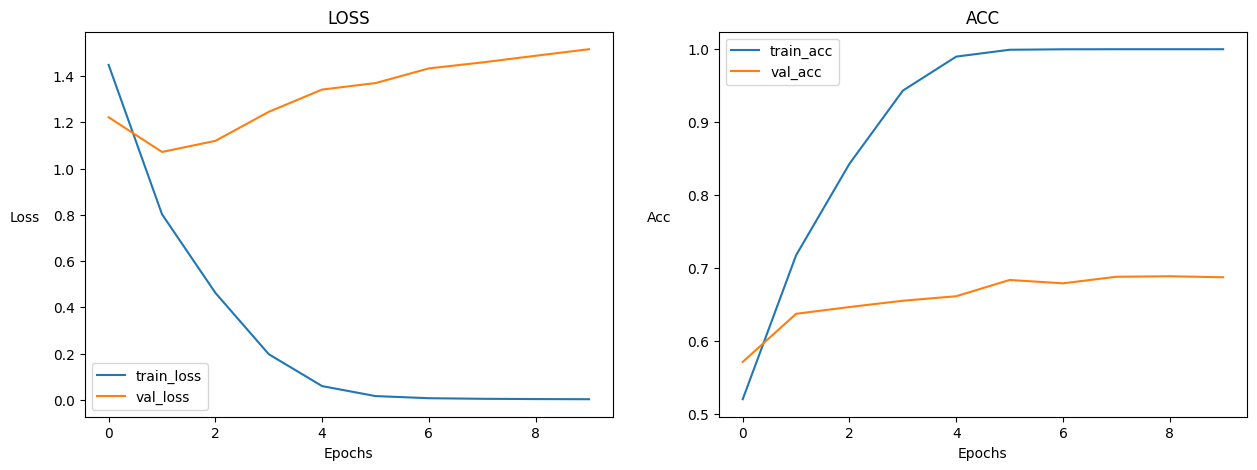

In [7]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label = 'train_acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.title('ACC')
plt.xlabel('Epochs')
plt.ylabel('Acc', rotation = 360, labelpad = 20)

plt.show()


In [8]:
def batch_extractor(batch_no, model, loader):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x
    labels = y.argmax(1)
    if i == batch_no - 1:
      break
  preds = model.predict(imgs).argmax(1)
  imgs = imgs * 255.
  imgs = imgs.astype(int)
  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

1/1 [==============================] - 0s 156ms/step


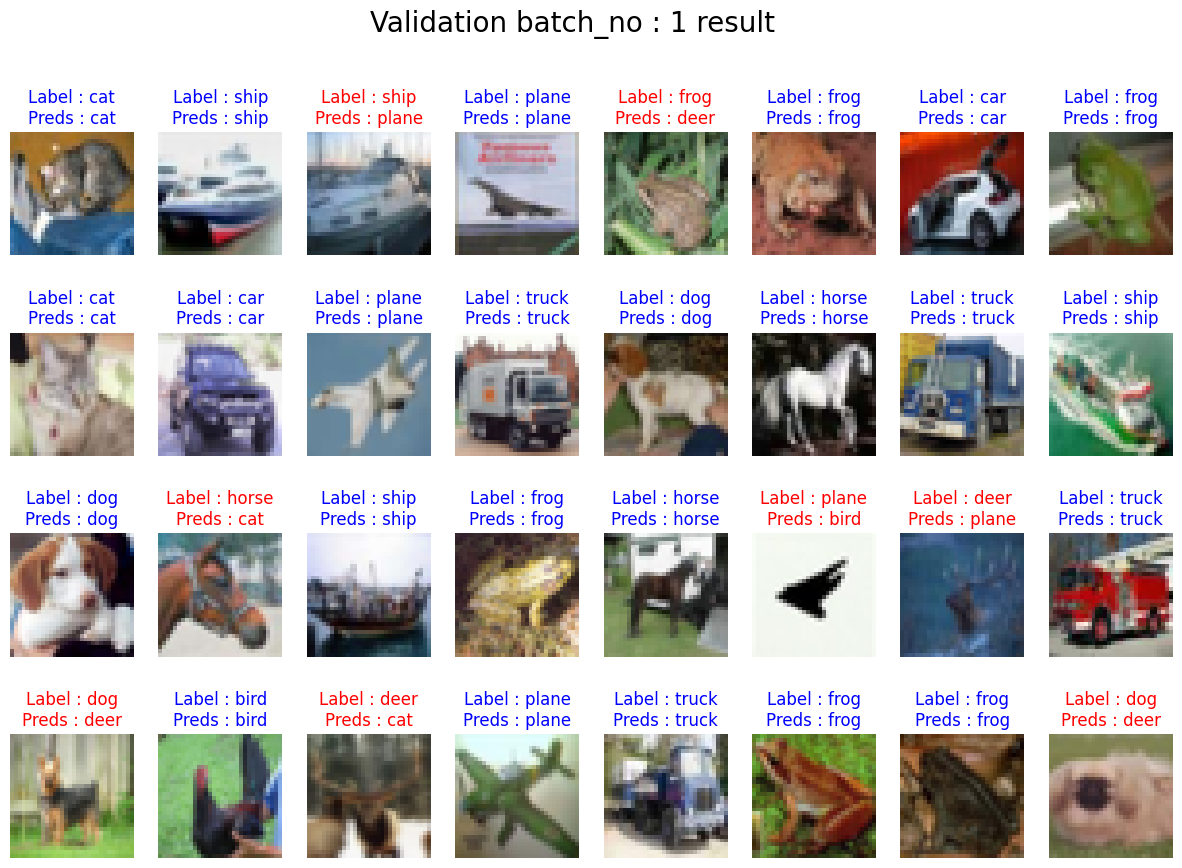

In [9]:
batch_no = 1
extract_dict = batch_extractor(batch_no = batch_no, model = model, loader = val_loader)

plt.figure(figsize = (15,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(extract_dict['imgs'][i])
  plt.axis('off')
  if extract_dict['preds'][i] == extract_dict['labels'][i]:
    color = "blue"
  else:
    color = "red"
  plt.title(f'Label : {label_name[extract_dict["labels"][i]]}\nPreds : {label_name[extract_dict["preds"][i]]}', color = color)
plt.suptitle(f"Validation batch_no : {batch_no} result", fontsize = 20)
plt.show()

In [11]:
preds = model.predict(X_val).argmax(1)
labels = y_val.argmax(1)

conf_array = np.zeros(10)
tmp_df = pd.DataFrame(conf_array)
conf_df = pd.DataFrame()
for i in range(10):
  conf_df = pd.concat([conf_df, tmp_df.T], axis = 0)
conf_df.index = [i for i in range(10)]

for i in range(len(preds)):
  conf_df.loc[labels[i], preds[i]] += 1
conf_df = conf_df.astype(int)
conf_df.index = label_name
conf_df.columns = label_name
conf_df

313/313 [==============================] - 1s 3ms/step


plane  car  bird  cat  deer  dog  frog  horse  ship  truck
plane    744   22    52   25    22    8    11     10    60     46
car       26  807    10   13     2    8    10      4    27     93
bird      82    9   530   67    91   70    76     46    15     14
cat       32   23    67  497    66  173    65     40    12     25
deer      28    5    72   67   637   38    65     75    10      3
dog       16    7    66  160    45  592    29     61    11     13
frog       8    9    45   62    48   25   780      6     9      8
horse     21    7    34   42    60   54    10    742     4     26
ship      80   49    15   19     5    6     6      4   784     32
truck     39   90    11   20     3   10     7     23    38    759

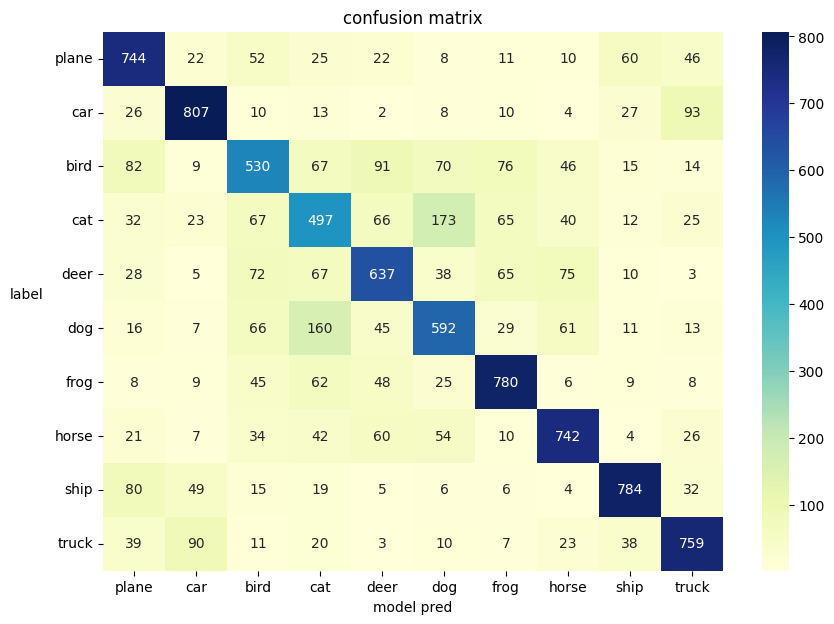

In [12]:
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot = True, fmt = 'd', cmap='YlGnBu')
plt.yticks(rotation = 360)
plt.xlabel('model pred')
plt.ylabel('label', rotation = 360, labelpad = 20)
plt.title('confusion matrix')
plt.show()

In [13]:
wrong_img = []
wrong_label = []
wrong_pred = []

for i in range(len(preds)):
  if preds[i] != labels[i]:
    restore_X = X_val[i] * 255.

    wrong_img.append(restore_X.astype(int))
    wrong_label.append(labels[i])
    wrong_pred.append(preds[i])

wrong_img = np.array(wrong_img)
wrong_label = np.array(wrong_label)
wrong_pred = np.array(wrong_pred)

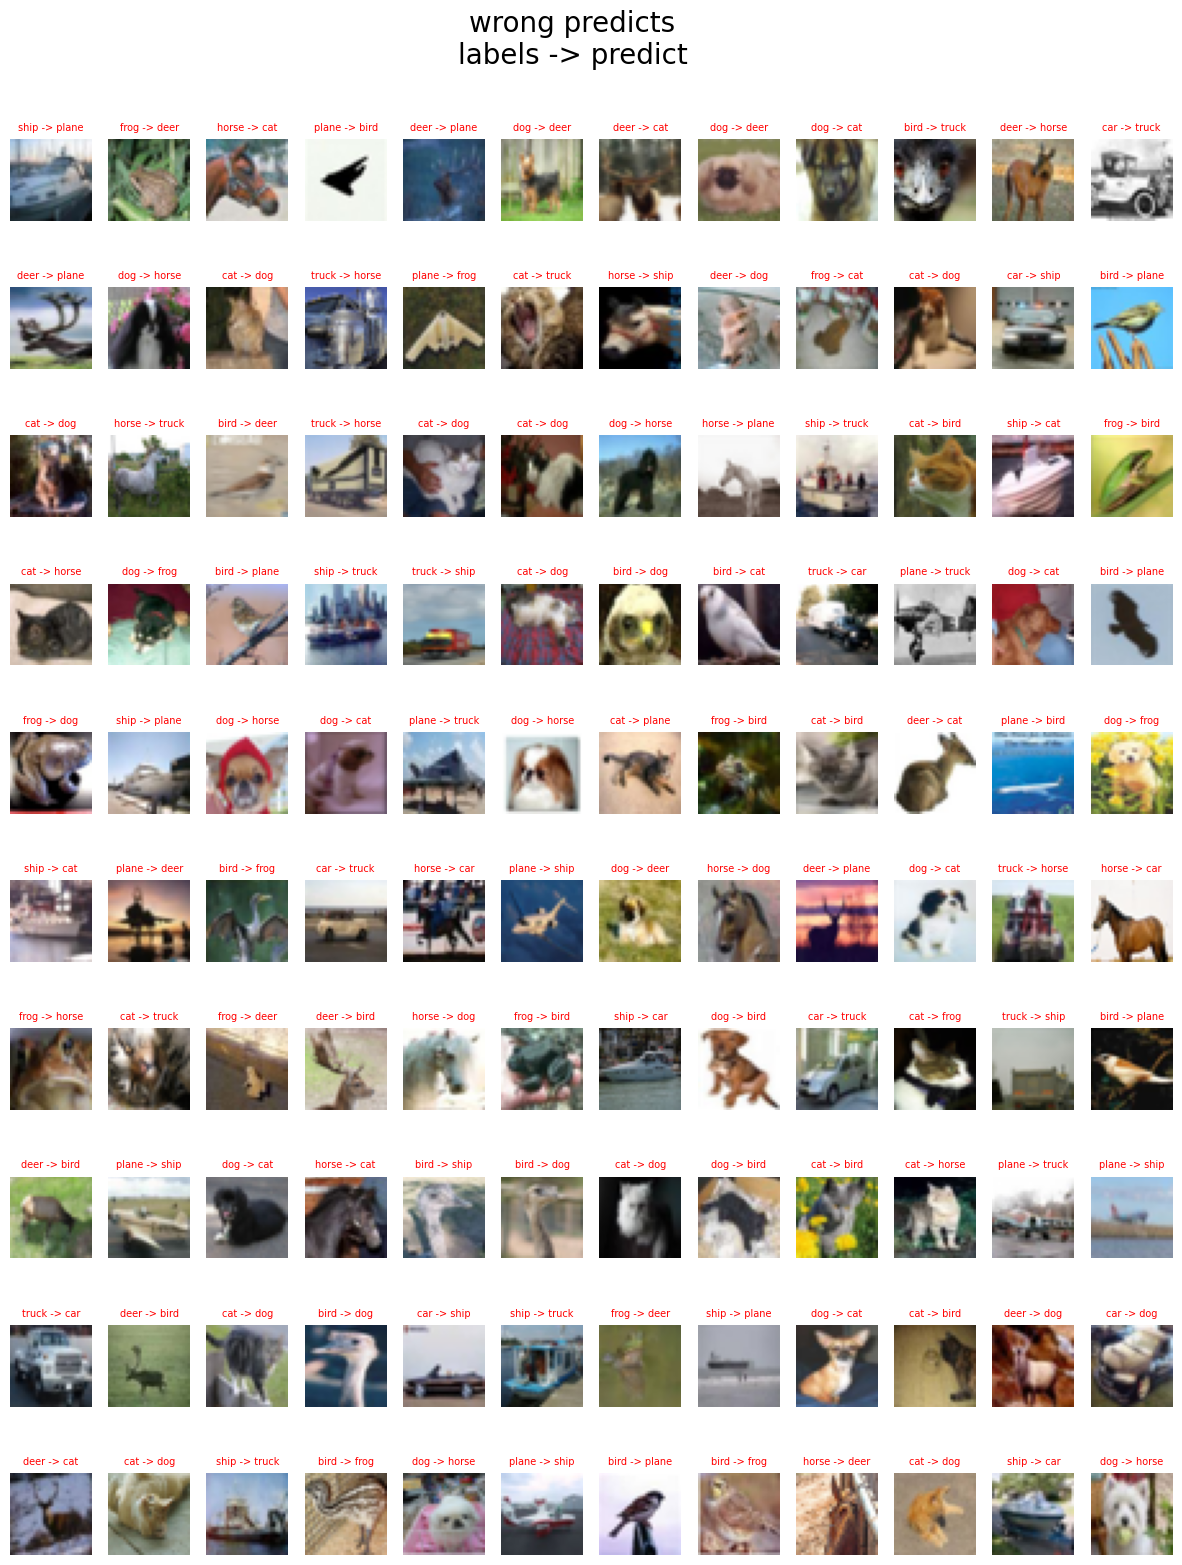

In [14]:
plt.figure(figsize = (15,18))
for i in range(len(wrong_img)):
  plt.subplot(10, 12, i + 1)
  plt.imshow(wrong_img[i])
  plt.axis('off')
  plt.title(f'{label_name[wrong_label[i]]} -> {label_name[wrong_pred[i]]}', color = "red", fontsize = 7)
  if i > 118:
    break
plt.suptitle("wrong predicts\nlabels -> predict", fontsize = 20)
plt.subplots_adjust(top=0.92)
plt.show()

# Pytorch MNIST 분류

In [15]:
import torch
from torch import nn
from torchvision import transforms, datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
)

train_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
val_dataset = datasets.CIFAR10(root = './data', train = False, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13186475.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


torch.Size([3, 32, 32])


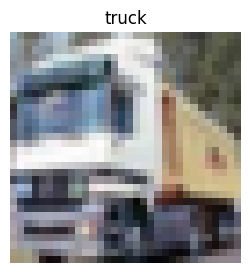

In [17]:
plt.figure(figsize = (3,3))
for x, y in train_loader:
  imgs = x[1]
  print(imgs.shape)
  imgs = imgs / 2 + 0.5
  imgs = imgs.numpy()
  plt.imshow(np.transpose(imgs, (1,2,0)))
  plt.axis('off')
  plt.title(f'{label_name[y[1]]}')
  break

In [18]:
class Simple_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.dense1 = nn.Sequential(
        nn.Linear(in_features = 64 * 28 * 28, out_features = 128),
        nn.ReLU()
    )
    # 파이토치의 nn.CrossEntropy는 softmax가 합쳐저 있으므로 따로 softmax층을 선언할 필요없음!!
    self.dense2 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    # flatten
    out = out.reshape(out.size(0), -1)
    out = self.dense1(out)
    out = self.dense2(out)
    return out

In [19]:
def train(model, loader, criterion, optimizer):
  '''
  학습을 위한 함수
  '''
  model.train()
  train_loss = 0.
  train_acc = 0.

  for X, y in loader:

    #X = X.view(32,1,28,28)
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # loss
    train_loss += loss.item()

    # acc
    pred = y_hat.max(1, keepdim = True)[1]
    train_acc += pred.eq(y.data.view_as(pred)).sum().item()

  train_loss  = train_loss / len(loader)
  train_acc = train_acc / len(loader.dataset)

  return train_loss, train_acc

def val(model, loader, criterion):
  '''
  검증을 위한 함수
  '''
  model.eval()
  val_loss = 0.
  val_acc = 0.

  with torch.no_grad():
    for X, y in loader:
      #X = X.view(32,1,28,28)
      X = X.to(device)
      y = y.to(device)

      y_hat = model(X)
      loss = criterion(y_hat, y)
      val_loss += loss.item()

      # acc
      pred = y_hat.max(1, keepdim = True)[1]
      val_acc += pred.eq(y.data.view_as(pred)).sum().item()

  val_loss  = val_loss / len(loader)
  val_acc = val_acc / len(loader.dataset)

  return val_loss, val_acc

In [20]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

model = Simple_CNN().to(device)

epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [21]:
st_loss = 1000

for epoch in range(epochs):
  print(f'########### epoch : {epoch + 1} ###########')
  train_loss, train_acc = train(model, train_loader, criterion, optimizer)
  val_loss, val_acc = val(model, val_loader, criterion)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
  if val_loss < st_loss:
    print(f'* train_loss = {train_loss}, train_acc = {train_acc}, val_acc = {val_acc}')
    print(f'* val_loss가 향상되었습니다. {st_loss} ==> {val_loss}')
    st_loss = val_loss
    torch.save(model.state_dict(), '/content/pytorch_CNN.pt')
  else:
    print(f'* train_loss = {train_loss}, train_acc = {train_acc}, val_acc = {val_acc}')
    print(f'* val_loss가 향상되지 않았습니다, val_loss = {val_loss}')

########### epoch : 1 ###########
* train_loss = 1.2420448616395077, train_acc = 0.55872, val_acc = 0.632
* val_loss가 향상되었습니다. 1000 ==> 1.033503539287127
########### epoch : 2 ###########
* train_loss = 0.7176812166364794, train_acc = 0.75102, val_acc = 0.6527
* val_loss가 향상되지 않았습니다, val_loss = 1.0409023264088693
########### epoch : 3 ###########
* train_loss = 0.34610610790121416, train_acc = 0.893, val_acc = 0.6602
* val_loss가 향상되지 않았습니다, val_loss = 1.1607331794997056
########### epoch : 4 ###########
* train_loss = 0.11017696038615936, train_acc = 0.97504, val_acc = 0.6729
* val_loss가 향상되지 않았습니다, val_loss = 1.264852692396977
########### epoch : 5 ###########
* train_loss = 0.032993625054403036, train_acc = 0.99572, val_acc = 0.6773
* val_loss가 향상되지 않았습니다, val_loss = 1.3453705650873673
########### epoch : 6 ###########
* train_loss = 0.012119735243209136, train_acc = 0.99926, val_acc = 0.6851
* val_loss가 향상되지 않았습니다, val_loss = 1.3707482469005463
########### epoch : 7 ###########
* tr

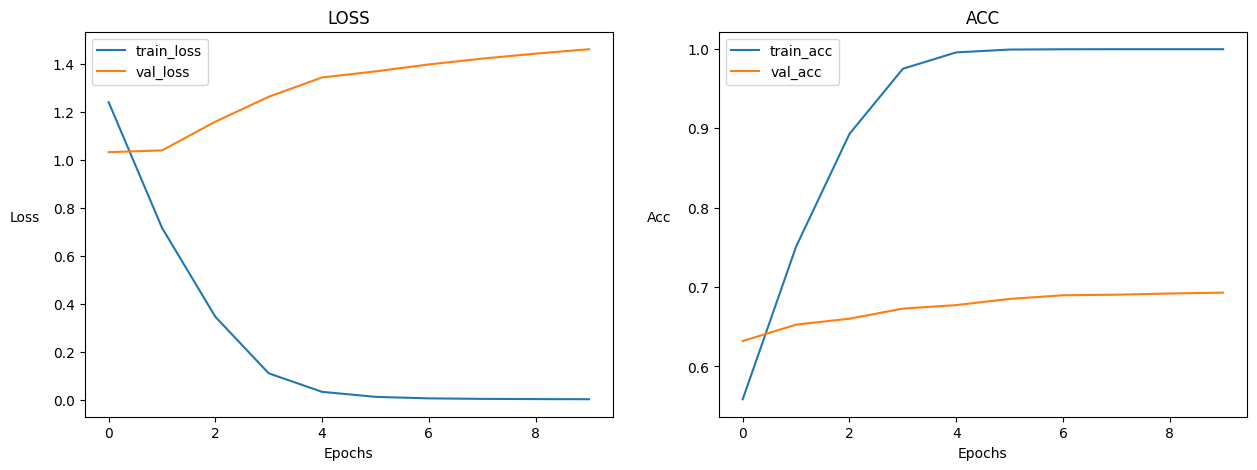

In [22]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)

plt.subplot(1,2,2)
plt.plot(train_acc_list, label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.legend()
plt.title('ACC')
plt.xlabel('Epochs')
plt.ylabel('Acc', rotation = 360, labelpad = 20)

plt.show()

In [23]:
def batch_extractor(batch_no, loader, model):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x.to(device)
    labels = y.numpy()
    if i == batch_no - 1:
      break
  model.eval()
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)

  imgs = imgs.detach().to('cpu').numpy() / 2 + 0.5
  imgs = np.transpose(imgs, (0,2,3,1))

  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

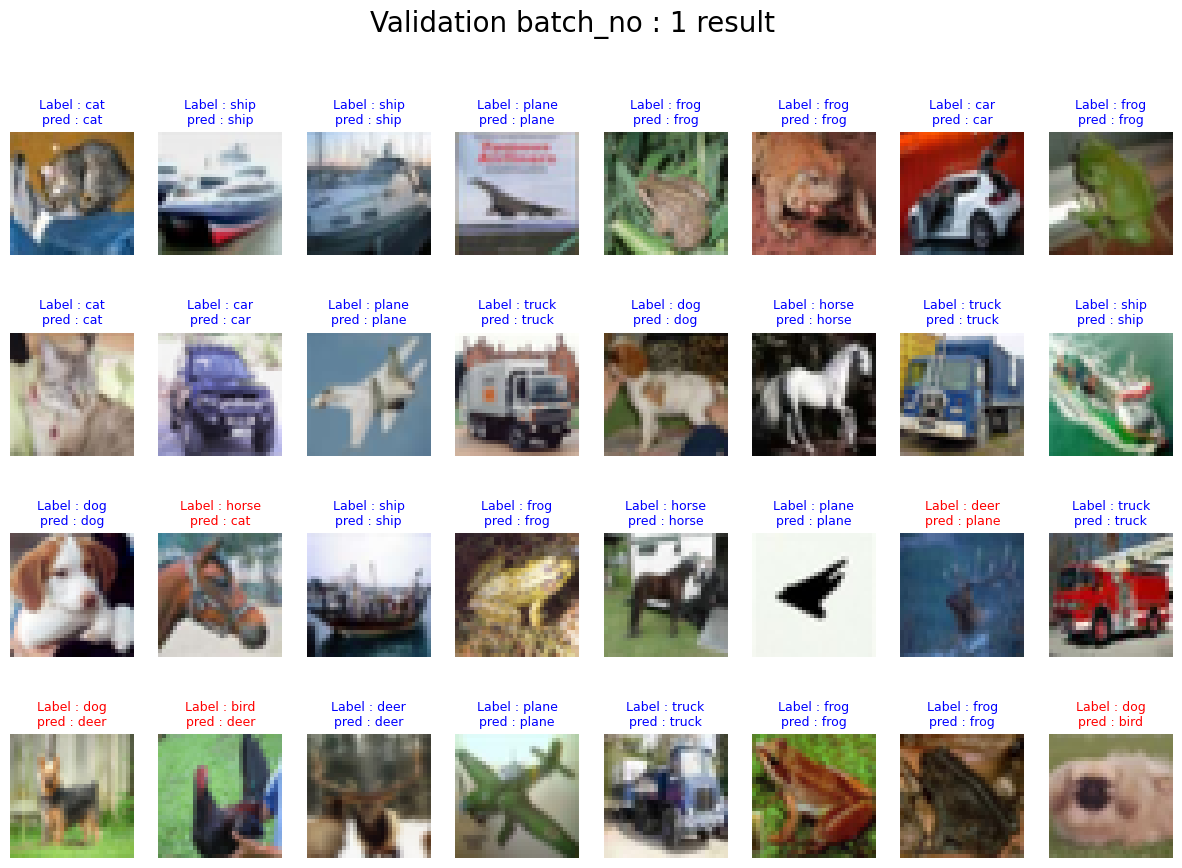

In [24]:
batch_no = 1
extract_dict = batch_extractor(batch_no = batch_no, loader = val_loader, model = model)
plt.figure(figsize = (15,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(extract_dict['imgs'][i])
  if extract_dict['preds'][i] == extract_dict['labels'][i]:
    color = "blue"
  else:
    color = "red"
  plt.title(f'Label : {label_name[extract_dict["labels"][i]]}\npred : {label_name[extract_dict["preds"][i]]}', color = color, fontsize = 9)
  plt.axis('off')
plt.suptitle(f'Validation batch_no : {batch_no} result', fontsize = 20)
plt.show()

In [25]:
labels = []
preds = []

model.eval()
with torch.no_grad():
  for img, label in val_loader:
    labels.append(label.numpy())

    img = img.to(device)
    pred = model(img).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
    preds.append(pred)

preds = np.array(preds).reshape(-1)
labels = np.array(labels).reshape(-1)

In [26]:
tmp_df = pd.DataFrame(np.zeros(10).T)
conf_df = pd.DataFrame()
for i in range(10):
  conf_df = pd.concat([conf_df, tmp_df], axis = 1)
conf_df.index = [i for i in range(10)]
conf_df.columns = [i for i in range(10)]

for i in range(len(labels)):
  conf_df.loc[labels[i], preds[i]] += 1
conf_df = conf_df.astype(int)
conf_df.index = label_name
conf_df.columns = label_name
conf_df

plane  car  bird  cat  deer  dog  frog  horse  ship  truck
plane    751   27    44   23    16   11    10     10    69     37
car       20  807    12   13     1    3    10      2    33     98
bird      80    8   557   73    91   60    66     41    11     12
cat       24   13    76  484    70  184    81     33    13     19
deer      30    7    73   70   640   20    68     74    14      4
dog       18    9    58  158    52  602    27     62     4      7
frog      12    5    51   47    41   22   801      7     7      7
horse     20   10    45   44    67   65    11    716     1     18
ship      68   41    13   22     2    9     6      4   802     30
truck     40   82    15   15     8    6    10     23    31    770

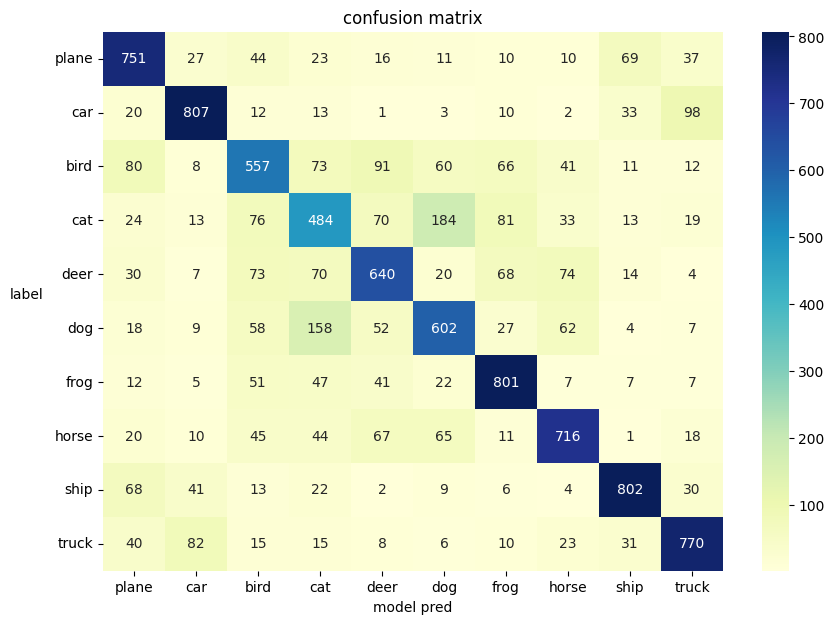

In [27]:
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot = True, fmt = 'd', cmap='YlGnBu')
plt.yticks(rotation = 360)
plt.xlabel('model pred')
plt.ylabel('label', rotation = 360, labelpad = 20)
plt.title('confusion matrix')
plt.show()

In [28]:
wrong_img = []
wrong_label = []
wrong_pred = []

for data in val_loader:
  x, y = data
  imgs = x.to(device)
  labels = y.numpy()
  model.eval()
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
  imgs = imgs.detach().to('cpu').numpy() / 2 + 0.5
  imgs = np.transpose(imgs, (0,2,3,1))

  for i in range(len(preds)):
    if preds[i] != labels[i]:
      wrong_img.append(imgs[i])
      wrong_label.append(labels[i])
      wrong_pred.append(preds[i])
wrong_img = np.array(wrong_img)
wrong_label = np.array(wrong_label)
wrong_pred = np.array(wrong_pred)

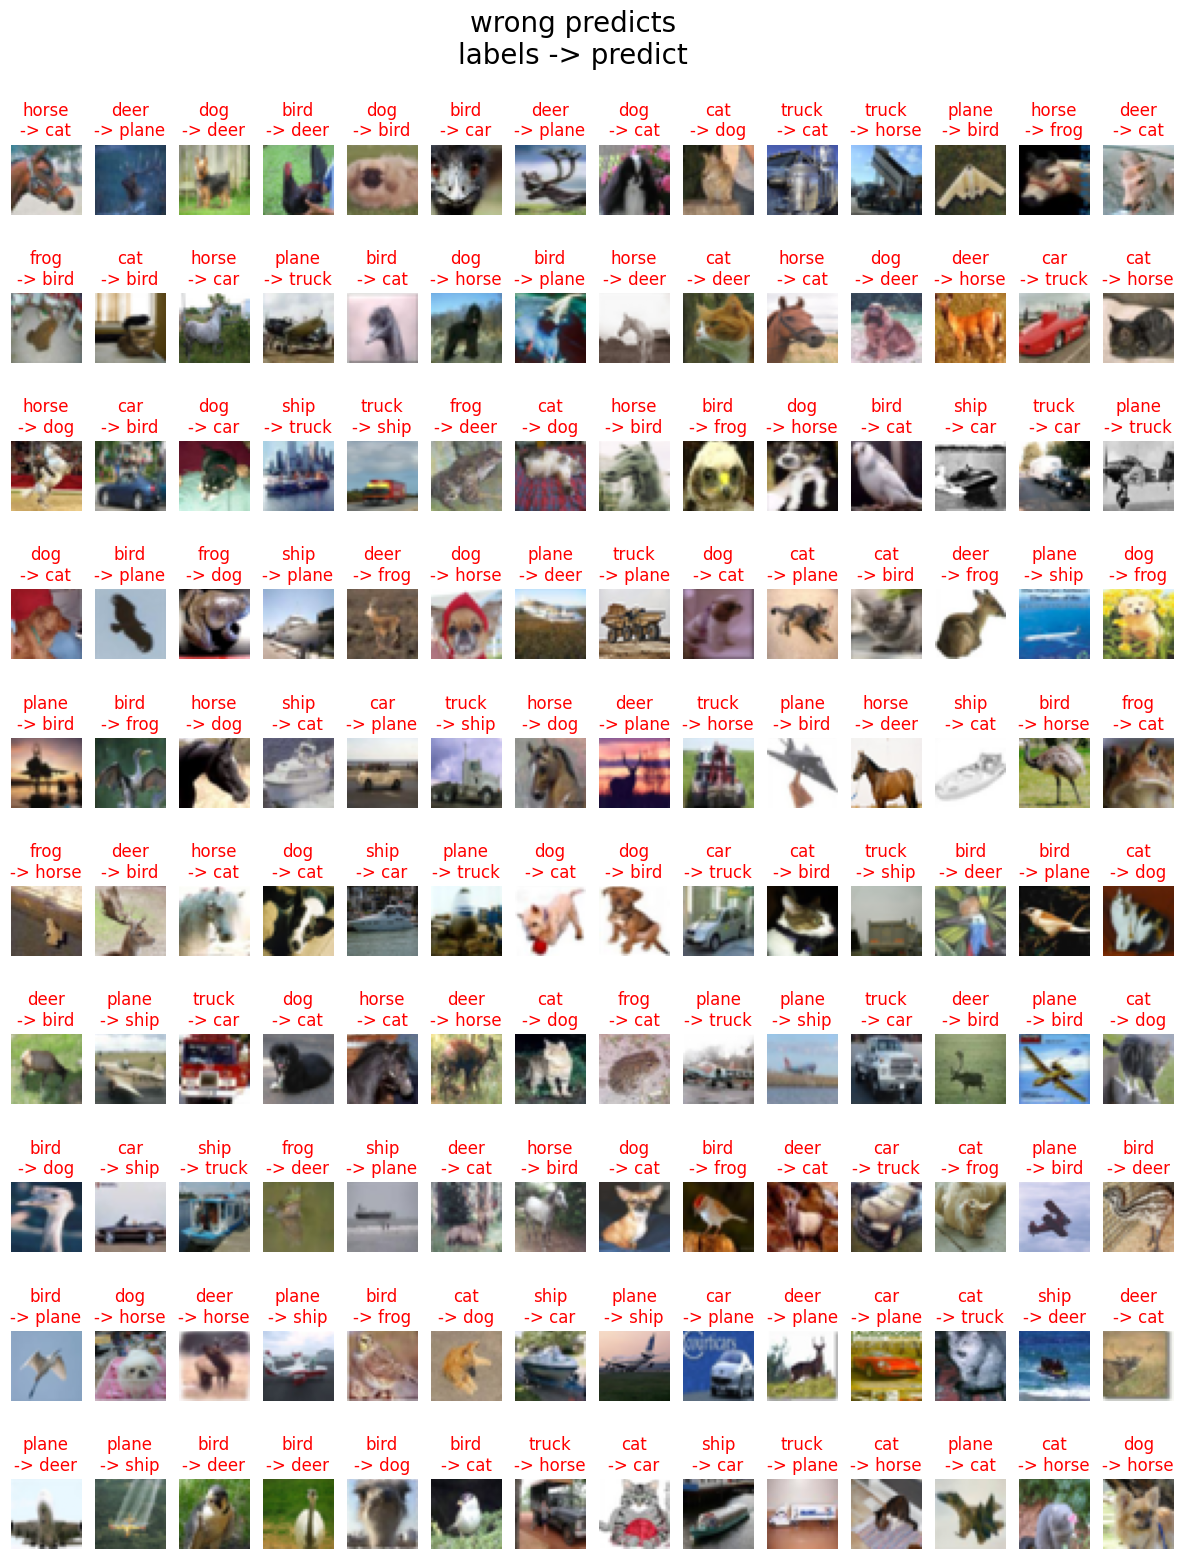

In [30]:
plt.figure(figsize = (15,18))
for i in range(len(wrong_img)):
  plt.subplot(10, 14, i + 1)
  plt.imshow(wrong_img[i], cmap = plt.cm.binary)
  plt.axis('off')
  plt.title(f'{label_name[wrong_label[i]]}\n-> {label_name[wrong_pred[i]]}', color = "red")
  if i > 138:
    break
plt.suptitle("wrong predicts\nlabels -> predict", fontsize = 20)
plt.subplots_adjust(top=0.92)
plt.show()